In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

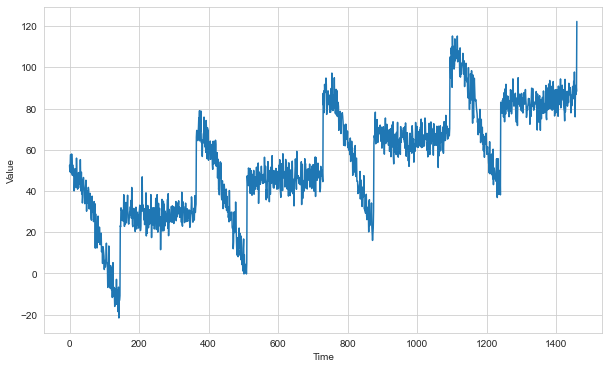

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [8]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [9]:
train_set = window_dataset(X_train,window_size,batch_size=128)

In [10]:
train_set

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [11]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [15]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 66ms/step - loss: 50.4952 - mae: 50.9947
Epoch 2/100
8/8 [==============================] - 1s 57ms/step - loss: 24.0846 - mae: 24.5775
Epoch 3/100
8/8 [==============================] - 1s 61ms/step - loss: 17.5152 - mae: 18.0045
Epoch 4/100
8/8 [==============================] - 1s 58ms/step - loss: 16.4850 - mae: 16.9762
Epoch 5/100
8/8 [==============================] - 0s 50ms/step - loss: 14.8457 - mae: 15.3344
Epoch 6/100
8/8 [==============================] - 0s 51ms/step - loss: 14.5539 - mae: 15.0444
Epoch 7/100
8/8 [==============================] - 0s 49ms/step - loss: 14.4429 - mae: 14.9320
Epoch 8/100
8/8 [==============================] - 0s 49ms/step - loss: 14.0597 - mae: 14.5469
Epoch 9/100
8/8 [==============================] - 0s 46ms/step - loss: 13.8142 - mae: 14.2998
Epoch 10/100
8/8 [==============================] - 0s 46ms/step - loss: 13.6719 - mae: 14.1591
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 1s 60ms/step - loss: 10994.5918 - mae: 10995.0918
Epoch 86/100
8/8 [==============================] - 1s 62ms/step - loss: 5167.8257 - mae: 5168.3257
Epoch 87/100
8/8 [==============================] - 1s 60ms/step - loss: 10951.3193 - mae: 10951.8184
Epoch 88/100
8/8 [==============================] - 1s 55ms/step - loss: 8105.2134 - mae: 8105.7134
Epoch 89/100
8/8 [==============================] - 0s 49ms/step - loss: 11076.2812 - mae: 11076.7812
Epoch 90/100
8/8 [==============================] - 0s 49ms/step - loss: 3253.5693 - mae: 3254.0693
Epoch 91/100
8/8 [==============================] - 0s 48ms/step - loss: 6406.5640 - mae: 6407.0640
Epoch 92/100
8/8 [==============================] - 0s 51ms/step - loss: 12274.4951 - mae: 12274.9951
Epoch 93/100
8/8 [==============================] - 0s 49ms/step - loss: 24648.2305 - mae: 24648.7324
Epoch 94/100
8/8 [==============================] - 1s 60ms/step - loss: 27071.8828 - mae: 27072.3809
E

(1e-07, 0.0001, 0.0, 30.0)

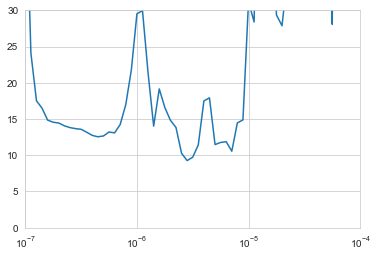

In [16]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size,batch_size=128)
valid_set = window_dataset(X_valid,window_size,batch_size=128)

In [18]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [20]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)

In [21]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 205ms/step - loss: 39.5999 - mae: 40.0961 - val_loss: 43.7533 - val_mae: 44.2533
Epoch 2/500
8/8 [==============================] - 1s 92ms/step - loss: 34.5527 - mae: 35.0508 - val_loss: 15.5834 - val_mae: 16.0789
Epoch 3/500
8/8 [==============================] - 1s 91ms/step - loss: 38.9090 - mae: 39.4081 - val_loss: 13.6249 - val_mae: 14.1183
Epoch 4/500
8/8 [==============================] - 1s 79ms/step - loss: 35.2863 - mae: 35.7835 - val_loss: 8.7141 - val_mae: 9.2066
Epoch 5/500
8/8 [==============================] - 1s 79ms/step - loss: 22.7035 - mae: 23.2007 - val_loss: 11.7205 - val_mae: 12.2165
Epoch 6/500
8/8 [==============================] - 1s 81ms/step - loss: 21.7347 - mae: 22.2293 - val_loss: 8.6972 - val_mae: 9.1904
Epoch 7/500
8/8 [==============================] - 1s 92ms/step - loss: 19.8715 - mae: 20.3665 - val_loss: 11.4279 - val_mae: 11.9219
Epoch 8/500
8/8 [==============================] - 1s 97ms/step -

In [22]:
model = keras.models.load_model("my_checkpoint.h5")

In [23]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
rnn_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

6.9609

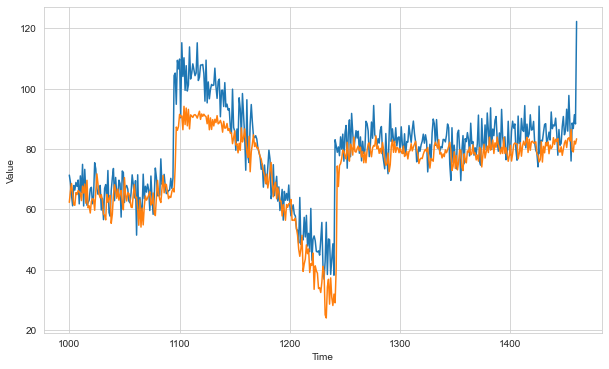

In [25]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)
print('\n')
keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy()

In [26]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
for X_batch,Y_batch in seq2_seq_window_dataset(tf.range(10),3,batch_size=1):
    print("X : ",X_batch.numpy())
    print("Y : ",Y_batch.numpy())

X :  [[[1]
  [2]
  [3]]]
Y :  [[[2]
  [3]
  [4]]]
X :  [[[2]
  [3]
  [4]]]
Y :  [[[3]
  [4]
  [5]]]
X :  [[[4]
  [5]
  [6]]]
Y :  [[[5]
  [6]
  [7]]]
X :  [[[3]
  [4]
  [5]]]
Y :  [[[4]
  [5]
  [6]]]
X :  [[[5]
  [6]
  [7]]]
Y :  [[[6]
  [7]
  [8]]]
X :  [[[6]
  [7]
  [8]]]
Y :  [[[7]
  [8]
  [9]]]
X :  [[[0]
  [1]
  [2]]]
Y :  [[[1]
  [2]
  [3]]]


In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [29]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [30]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [31]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/30))

In [32]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [33]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 58ms/step - loss: 52.3615 - mae: 52.8611
Epoch 2/100
8/8 [==============================] - 1s 55ms/step - loss: 25.4713 - mae: 25.9671
Epoch 3/100
8/8 [==============================] - 1s 48ms/step - loss: 23.5029 - mae: 23.9971
Epoch 4/100
8/8 [==============================] - 1s 47ms/step - loss: 21.1367 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 1s 49ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 1s 48ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 1s 55ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 1s 54ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 1s 54ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 1s 53ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 1s 46ms/step - loss: 49.8815 - mae: 50.3809
Epoch 87/100
8/8 [==============================] - 1s 47ms/step - loss: 50.3914 - mae: 50.8911
Epoch 88/100
8/8 [==============================] - 1s 45ms/step - loss: 52.1990 - mae: 52.6986
Epoch 89/100
8/8 [==============================] - 1s 53ms/step - loss: 62.0209 - mae: 62.5207
Epoch 90/100
8/8 [==============================] - 1s 53ms/step - loss: 56.5383 - mae: 57.0379
Epoch 91/100
8/8 [==============================] - 1s 52ms/step - loss: 59.5138 - mae: 60.0136
Epoch 92/100
8/8 [==============================] - 1s 53ms/step - loss: 62.6575 - mae: 63.1571
Epoch 93/100
8/8 [==============================] - 1s 53ms/step - loss: 75.6172 - mae: 76.1170
Epoch 94/100
8/8 [==============================] - 1s 55ms/step - loss: 88.9575 - mae: 89.4565
Epoch 95/100
8/8 [==============================] - 1s 54ms/step - loss: 91.3082 - mae: 91.8077
Epoch 96/100
8/8 [==============================] - 1

(1e-07, 0.0001, 0.0, 30.0)

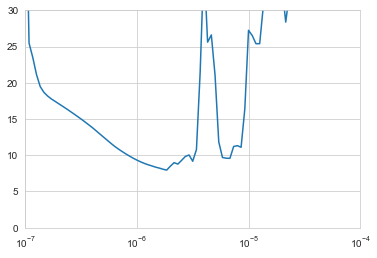

In [34]:
plt.semilogx(history.history['lr'],history.history["loss"])
plt.axis([1e-7,1e-4,0,30])

In [35]:
# Second

In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [37]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [38]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [39]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [40]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 5s 191ms/step - loss: 54.1427 - mae: 54.6412 - val_loss: 17.9209 - val_mae: 18.4158
Epoch 2/500
8/8 [==============================] - 1s 108ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5481 - val_mae: 21.0440
Epoch 3/500
8/8 [==============================] - 1s 106ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8711 - val_mae: 38.3705
Epoch 4/500
8/8 [==============================] - 1s 108ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2684 - val_mae: 25.7674
Epoch 5/500
8/8 [==============================] - 1s 107ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8504
Epoch 6/500
8/8 [==============================] - 1s 107ms/step - loss: 15.0382 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 1s 105ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 1s 97ms/

Epoch 63/500
8/8 [==============================] - 1s 103ms/step - loss: 6.3027 - mae: 6.7813 - val_loss: 5.4634 - val_mae: 5.9396
Epoch 64/500
8/8 [==============================] - 1s 109ms/step - loss: 6.2800 - mae: 6.7595 - val_loss: 5.6596 - val_mae: 6.1384
Epoch 65/500
8/8 [==============================] - 1s 107ms/step - loss: 6.2597 - mae: 6.7382 - val_loss: 5.4920 - val_mae: 5.9685
Epoch 66/500
8/8 [==============================] - 1s 109ms/step - loss: 6.2370 - mae: 6.7161 - val_loss: 5.5227 - val_mae: 5.9986
Epoch 67/500
8/8 [==============================] - 1s 105ms/step - loss: 6.2181 - mae: 6.6968 - val_loss: 5.5079 - val_mae: 5.9838
Epoch 68/500
8/8 [==============================] - 1s 94ms/step - loss: 6.1976 - mae: 6.6767 - val_loss: 5.5154 - val_mae: 5.9910
Epoch 69/500
8/8 [==============================] - 1s 85ms/step - loss: 6.1796 - mae: 6.6588 - val_loss: 5.5413 - val_mae: 6.0176
Epoch 70/500
8/8 [==============================] - 1s 109ms/step - loss: 6.16

In [41]:
rnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

In [42]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

5.458861




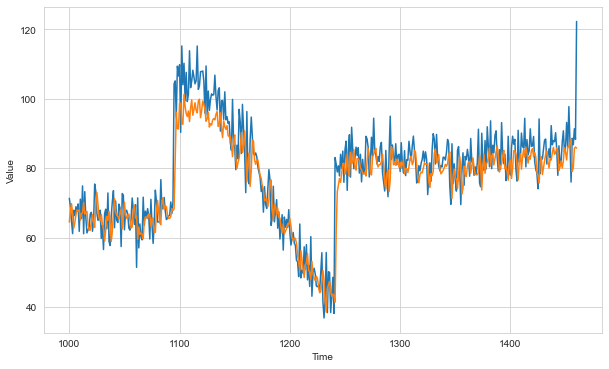

In [43]:
print(keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy())
print('\n')
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

In [44]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [45]:
for X_batch,Y_batch in sequential_window_dataset(tf.range(10),3):
    print(X_batch.numpy(),Y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [46]:
class RestStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [49]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)

In [50]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))

In [51]:
reset_states = RestStatesCallback()

In [52]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [53]:
history = model.fit(train_set,epochs=100,
                   callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 4s 25ms/step - loss: 5.9052 - mae: 6.3829
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 5.9055 - mae: 6.3866
Epoch 3/100
33/33 [==============================] - 1s 25ms/step - loss: 5.9024 - mae: 6.3835
Epoch 4/100
33/33 [==============================] - 1s 24ms/step - loss: 5.9009 - mae: 6.3820
Epoch 5/100
33/33 [==============================] - 1s 24ms/step - loss: 5.8992 - mae: 6.3804
Epoch 6/100
33/33 [==============================] - 1s 25ms/step - loss: 5.8975 - mae: 6.3788
Epoch 7/100
33/33 [==============================] - 1s 24ms/step - loss: 5.8959 - mae: 6.3773
Epoch 8/100
33/33 [==============================] - 1s 25ms/step - loss: 5.8941 - mae: 6.3755
Epoch 9/100
33/33 [==============================] - 1s 24ms/step - loss: 5.8921 - mae: 6.3734
Epoch 10/100
33/33 [==============================] - 1s 24ms/step - loss: 5.8900 - mae: 6.3711
Epoch 11/100
33/33 [=============================

33/33 [==============================] - 1s 25ms/step - loss: 36.5736 - mae: 37.0706
Epoch 86/100
33/33 [==============================] - 1s 24ms/step - loss: 27.4444 - mae: 27.9416
Epoch 87/100
33/33 [==============================] - 1s 25ms/step - loss: 28.3457 - mae: 28.8448
Epoch 88/100
33/33 [==============================] - 1s 25ms/step - loss: 30.0704 - mae: 30.5669
Epoch 89/100
33/33 [==============================] - 1s 26ms/step - loss: 37.5227 - mae: 38.0218
Epoch 90/100
33/33 [==============================] - 1s 25ms/step - loss: 50.0445 - mae: 50.5433
Epoch 91/100
33/33 [==============================] - 1s 24ms/step - loss: 30.2365 - mae: 30.7320
Epoch 92/100
33/33 [==============================] - 1s 23ms/step - loss: 30.5368 - mae: 31.0314
Epoch 93/100
33/33 [==============================] - 1s 21ms/step - loss: 58.0045 - mae: 58.5019
Epoch 94/100
33/33 [==============================] - 1s 21ms/step - loss: 40.7620 - mae: 41.2593
Epoch 95/100
33/33 [=============

In [54]:
#model = keras.models.load_model("my_checkpoint.h5")
#model.reset_states()

In [55]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])
rnn_forecast = rnn_forecast[0, split_time -1 :-1, 0]

In [56]:
rnn_forecast.shape

(461,)

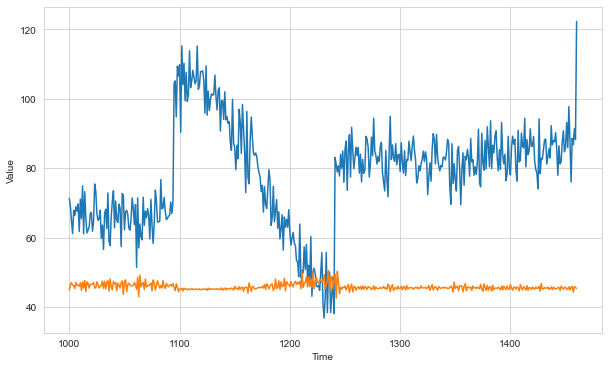

In [57]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)